In [134]:
import numpy as np
import os
import pandas as pd
from datetime import timedelta
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [135]:
def get_filename_list(my_dir):
    import os
    a=[]
    for root, dirs, files in os.walk(my_dir):
        for name in files:
            if name.endswith((".csv")):
                new_name=os.path.join(root,name)
                #new_name=dirs+name
                a.append(new_name)
    return a

In [136]:
def process_dur(data):
    time_difference = pd.to_datetime(data['set_T'],unit='s')-pd.to_datetime(data['rise_T'],unit='s')
    time_difference_in_minutes = time_difference / timedelta(minutes=1)
    data['dur']=time_difference_in_minutes
    return data


In [137]:
def preprocess_xgb(data):
    new_data=data.copy()
    new_data['month'] = new_data.StartTime.str[5:7]
    month_id=['01','02','03','04','05','06','07','08','09','10','11','12']
    month_name=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    sLength = len(new_data.Lse_header)
    new_data['month_name'] = pd.Series(np.random.randn(sLength), index=new_data.index)
    for k in range(0,12):
        new_data.month_name[new_data.month==month_id[k]]=month_name[k]
    new_data=new_data.sort_values(by='StartTime')
    return new_data

In [138]:
def split_test_train(new_data,month):
    rot_month_id=['01','02','03','04','05','06','07','08','09','10','11','12']
    month_col=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    m_id=month_col.index(month)
    rot_month_name=['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar']
    i=m_id+3
    data_1=new_data[new_data['month_name']==rot_month_name[i-1]]
    data_2=new_data[new_data['month_name']==rot_month_name[i-2]]
    data_3=new_data[new_data['month_name']==rot_month_name[i-3]]
    data1=new_data[new_data['month_name']==rot_month_name[i+1]]
    data2=new_data[new_data['month_name']==rot_month_name[i+2]]
    data3=new_data[new_data['month_name']==rot_month_name[i+3]]
    train_frame=[data_3,data_2,data_1,data1,data2,data3]
    train=pd.concat(train_frame,ignore_index=False)
    train = train.reset_index(drop=True)

    test=new_data[new_data['month_name']==rot_month_name[i]]
    #test_frame=[test_data]
    #test=pd.concat(test_frame,ignore_index=True)
    test = test.reset_index(drop=True)


    print('test dimension:')
    print(len(test['High']))
    print('train dimension:')
    print(len(train['High']))
    return train,test

In [139]:
def process_train_test(train,test):
    Ytrain=train['daily_consumption']
    Xtrain=train.drop(['daily_consumption'], axis=1)
    Xtrain=Xtrain.drop(['TDSPName','ServiceZip','LseHeaderID','StartTime','StopTime','Lse_header','month','month_name','rise_T','set_T'], axis=1)
    Ytest=test['daily_consumption']
    Xtest=test.drop(['daily_consumption'], axis=1)
    Xtest=Xtest.drop(['TDSPName','ServiceZip','LseHeaderID','StartTime','StopTime','Lse_header','month','month_name','rise_T','set_T'], axis=1)
    return Xtrain,Xtest,Ytrain,Ytest

In [140]:
def run_classifier(train,test):
    Ytrain=train['daily_consumption']
    Xtrain=train.drop(['daily_consumption'], axis=1)
    Xtrain=Xtrain.drop(['TDSPName','ServiceZip','LseHeaderID','StartTime','StopTime','Lse_header','month','month_name','rise_T','set_T'], axis=1)
    Ytest=test['daily_consumption']
    Xtest=test.drop(['daily_consumption'], axis=1)
    Xtest=Xtest.drop(['TDSPName','ServiceZip','LseHeaderID','StartTime','StopTime','Lse_header','month','month_name','rise_T','set_T'], axis=1)
    
    dtrain = xgb.DMatrix(Xtrain,label=Ytrain)
    dtest = xgb.DMatrix(Xtest,label=Ytest)
    # specify parameters via map
    #param = {'max_depth':21, 'eta':0.07, 'nthread' : 8,'silent':1, 'objective':'reg:linear' ,'gamma' : 0}
    param = {'max_depth':21, 'eta':0.07, 'nthread' : 8,'silent':1, 'objective':'reg:linear' ,'gamma' : 0, 'nthread' :8, 'min_child_weight': 8, 'subsample': 0.95, 'colsample_bytree': 0.7, 'alpha': 0,'lambda': 0}

    num_round = 100
    bst = xgb.train(param, dtrain, num_round)
    # make prediction
    preds = bst.predict(dtest)
    
    return preds,Ytest

In [141]:
def plot_prediction(preds,Ytest,file_name):
    file1 = get_file(file_name)
    plt.plot( Ytest, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label="actual")
    plt.plot( preds, marker='', color='olive',markersize=12, linewidth=2, label="prediction")
    plt.ylabel('daily consumption (KWH)')
    plt.xlabel('day_index')
    plt.title('consumption profile actual and prediction')
    plt.savefig(file1)
    plt.legend()

In [148]:
def get_file(file_name):
    n_file=file_name[42:-4]
    list1=['C:/Users/ruchi/Desktop/Predictions/',n_file,'_plot_prediction.png']
    file1=''.join(list1)
    return file1

In [149]:
def get_accuracy(preds,Ytest):
    accuracy=np.abs(np.sum(Ytest)-np.sum(preds))/np.sum(Ytest)
    print("Accuracy: %.3f" % ((1-accuracy) * 100.0))

C:\Users\ruchi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\ruchi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


test dimension:
31
train dimension:
181
Accuracy: 91.115


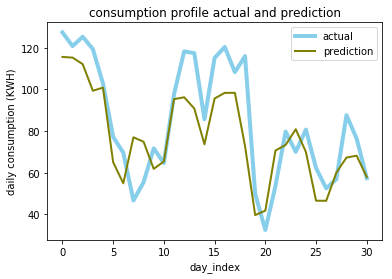

In [150]:
my_dir= "C:/Users/ruchi/Desktop/WeatherData/"
filenames=get_filename_list(my_dir)
f=filenames[0]
data=pd.read_csv(f)
data=process_dur(data)
new_data=preprocess_xgb(data)

month='Jan'
train,test = split_test_train(new_data,month)
Xtrain,Xtest,Ytrain,Ytest = process_train_test(train,test)
preds,Ytest = run_classifier(train,test)
plot_prediction(preds,Ytest,f)
get_accuracy(preds,Ytest)